In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F# define la arquitectura de RN 

## Preproceso de datos

In [3]:
num_workers = 0 #Numero de subprocesos a emplear para lectura de datos
batch_size = 20 #Cuantos datos contendra cada conjunto 
validation_size = .2 #tamano de conjunto de validacion
transform = transforms.ToTensor() #Convierte los datos a torch.FloatTensor
# Carga de conjunto de entrenamiento y prueba
entrena_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
prueba_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)
#Obteniendo los indices de entrenamiento que seran empleados para validacion
num_entrena = len(entrena_data)
indices = list(range(num_entrena))
np.random.shuffle(indices)
part = int(np.floor(validation_size * num_entrena))
#Define el tamano para conjunto de entrenamiento y validacion
entrena_ind, valida_ind = indices[part:], indices[:part]
#Definimos los conjuntos de entrenamiento y validacion
entrena_mues = SubsetRandomSampler(entrena_ind)
valida_mues = SubsetRandomSampler(valida_ind)
#Lectores de datos
entrena_lec = torch.utils.data.DataLoader(entrena_data, batch_size = batch_size, 
                                           sampler = entrena_mues, num_workers = num_workers)
valida_lec = torch.utils.data.DataLoader(entrena_data, batch_size = batch_size,
                                          sampler = valida_mues, num_workers = num_workers)
prueba_lec = torch.utils.data.DataLoader(prueba_data, batch_size = batch_size,
                                         num_workers = num_workers)

/tmp/ipykernel_12483/3397805297.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2,20/2, idx+1, xticks=[], yticks=[])


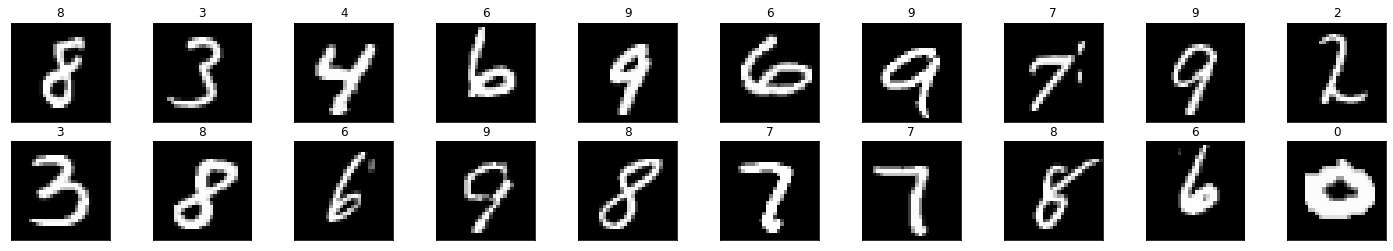

In [6]:
#Verificar si los datos se han leido correctamente
#Se toma un conjunto con tamano del batch
data_iter = iter(entrena_lec)
img, etiquetas = data_iter.next()
img = img.numpy()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img[idx]), cmap = 'gray')
    ax.set_title(str(etiquetas[idx].item()))

# Arquitectura

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        # numero de nodos en capas ocultas
        oculta_1 = 512
        oculta_2 = 512
        oculta_3 = 512
        # linear layer (784 -> oculta_1)
        self.fc1 = nn.Linear(28*28, oculta_1)
        # linear layer (n_oculta-> oculta_2)
        self.fc2 = nn.Linear(oculta_1, oculta_2)
        # linear layer (n_oculta -> oculta_3)
        self.fc3 = nn.Linear(oculta_2,oculta_3)
        # linear layer (n_oculta -> 10) 
        # 10 es el numero de salidas
        self.fc4 = nn.Linear(oculta_3,10)
        # dropout layer (p=0.2) 
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # aplana la imagen de entrada
        x = x.view(-1,28*28)
        # se agrega capa oculta con ReLU como funcion de activacion
        x = F.relu(self.fc1(x))
        # capa de dropout
        x = self.droput(x)
        # se agrega capa oculta con ReLU como funcion de activacion
        x = F.relu(self.fc2(x))
        # capa de dropout
        x = self.droput(x)
        # se agrega capa oculta con ReLU como funcion de activacion
        x = F.relu(self.fc3(x))
        # capa de dropout
        x = self.droput(x)
        # Capa de salida
        x = self.fc4(x)
        return x
    
# inicializa el MLP
model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [10]:
# especificar loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# especificar optimizer (stochastic gradient descent) 
# con un indice de aprendizaje(learning rate) = .01
optim = torch.optim.SGD(model.parameters(),lr = 0.01)

## Entrenamiento 

In [13]:
# numero de epocas para entrenar el MLP
n_epocas = 1
# inicializar un seguidor para un valor minimo de perdida
valida_loss_min = np.Inf  # set initial "min" to infinity

for epocas in range(n_epocas):
    # monitorear las perdidas
    entrena_loss = 0
    valida_loss = 0
    
    ######Entrenamiento del modelo
    model.train() # prepara el  modelo para entrenamiento
    for data,etiqueta in entrena_lec:
        # Limpiar los gradientes para las variables optimizadas
        optim.zero_grad()
        salida = model(data)
        # calcula la perdida
        loss = criterion(salida,etiqueta)
        # Calculo del gradiente de perdida con respecto a los parametros del modelo
        loss.backward()
        optim.step()
        # Actualiza la perdidad 
        entrena_loss += loss.item() * data.size(0)
        
        
     ####### Validacion del modelo 
    model.eval()  # Se inicia el modelo para la evaluacion
    for data,etiqueta in valida_lec:
        # Computa las predicciones de salida pasando las entradas al modelo 
        salida = model(data)
        # Calcula la perdida
        loss = criterion(salida,etiqueta)
        # Actualiza el valor de perdida
        valida_loss = loss.item() * data.size(0)
    
    # calculo de perdida promedio por epoca
    entrena_loss = entrena_loss / len(entrena_lec.sampler)
    valida_loss = valida_loss / len(valida_lec.sampler)
    
    print('Epoca: {} \tPerdida entrenamiento: {:.6f} \tPerdida validacion: {:.6f}'.format(
        epocas+1, 
        entrena_loss,
        valida_loss
        ))
    
    # Almacena los parametros del modelo si disminuye la perdida
    if valida_loss <= valida_loss_min:
        print('Perdida de validacion disminuyo ({:.6f} --> {:.6f}).  Almaceno el modelo ...'.format(
        valida_loss_min,
        valida_loss))
        torch.save(model.state_dict(), 'modelo1.pt')
        valida_loss_min = valida_loss

Epoca: 1 	Perdida entrenamiento: 0.285176 	Perdida validacion: 0.000260
Perdida de validacion disminuyo (inf --> 0.000260).  Almaceno el modelo ...


# Prueba del MLP

In [14]:
model.load_state_dict(torch.load('modelo1.pt'))

<All keys matched successfully>

In [18]:
prueba_loss = 0.0
clas_correct = list(0. for i in range(10))
clas_total = list(0. for i in range(10))

model.eval() 

for data, target in prueba_lec:
    
    output = model(data)
    loss = criterion(output, target)
    prueba_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    #Comparar las etiquetas con las predicciones
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # Calculo de la precision para cada clase
    for i in range(len(target)):
        label = target.data[i]
        clas_correct[label] += correct[i].item()
        clas_total[label] += 1
prueba_loss = prueba_loss/len(prueba_lec.sampler)
print('Perdida de prueba: {:.6f}\n'.format(prueba_loss))

for i in range(10):
    if clas_total[i] > 0:
        print('Precision de prueba de %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * clas_correct[i] / clas_total[i],
            np.sum(clas_correct[i]), np.sum(clas_total[i])))
    else:
        print('Precision de prueba de %5s: N/A (no hay ejemplos)' % (classes[i]))
        print('\nPrcision de prueba: %2d%% (%2d/%2d)' % (
    100. * np.sum(clas_correct) / np.sum(clas_total),
    np.sum(clas_correct), np.sum(clas_total)))

Perdida de prueba: 0.211218

Precision de prueba de     0: 97% (960/980)
Precision de prueba de     1: 98% (1116/1135)
Precision de prueba de     2: 93% (961/1032)
Precision de prueba de     3: 95% (965/1010)
Precision de prueba de     4: 94% (929/982)
Precision de prueba de     5: 88% (787/892)
Precision de prueba de     6: 96% (924/958)
Precision de prueba de     7: 92% (951/1028)
Precision de prueba de     8: 88% (863/974)
Precision de prueba de     9: 91% (925/1009)


/tmp/ipykernel_12483/106672302.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2,20/2, idx+1, xticks=[], yticks=[])


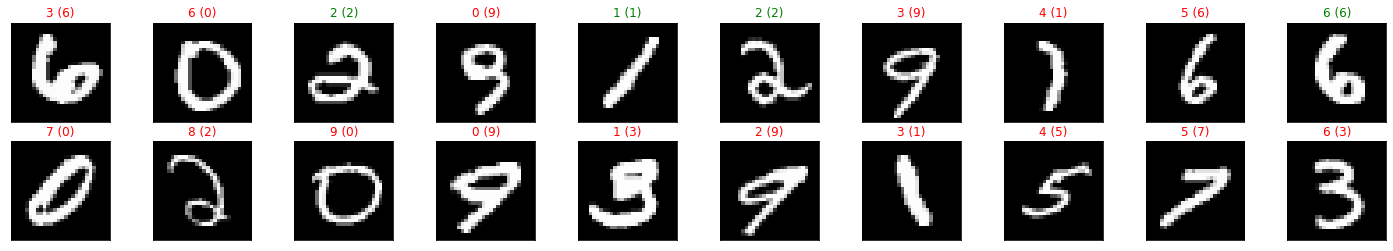

In [21]:
#Se toma un conjunto con tamano del batch
data_iter = iter(entrena_lec)
img, etiquetas = data_iter.next()
# predicciones del MLP
salida = model(img)
_, preds = torch.max(output, 1)
#Desplegar las imagenes
img = img.numpy()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img[idx]), cmap = 'gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(etiquetas[idx].item())),
                 color=("green" if preds[idx]==etiquetas[idx] else "red"))